In [31]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from pydub import AudioSegment
from scipy.interpolate import interp1d

In [32]:
mp3_path = "/content/german_voice_quest.mp3"   # <-- Replace with your file
wav_path = "/content/GERMAN_VOICE_QUEST.wav"   # output file

# Convert using pydub
audio = AudioSegment.from_mp3(mp3_path)
audio.export(wav_path, format="wav")

<_io.BufferedRandom name='/content/GERMAN_VOICE_QUEST.wav'>

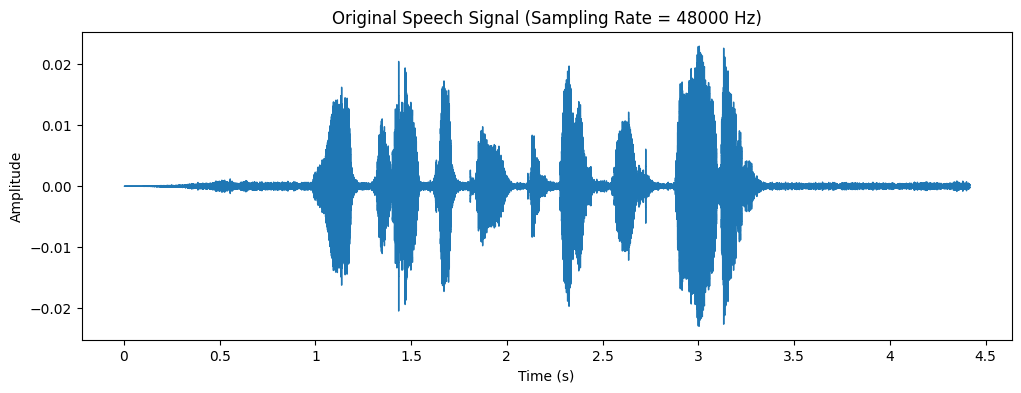

In [33]:
# (a) Load original speech
# ---------------------------
file_path = "/content/ENGLISH_VOICE_QUEST.wav"
signal, sr = librosa.load(file_path, sr=None)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(signal, sr=sr)
plt.title(f"Original Speech Signal (Sampling Rate = {sr} Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [34]:
# (b) Resample to 8kHz, 16kHz, 44.1kHz
# ---------------------------
target_rates = [8000, 16000, 44100]
resampled_signals = {}

for target_sr in target_rates:
    resampled = librosa.resample(signal, orig_sr=sr, target_sr=target_sr)
    resampled_signals[target_sr] = resampled


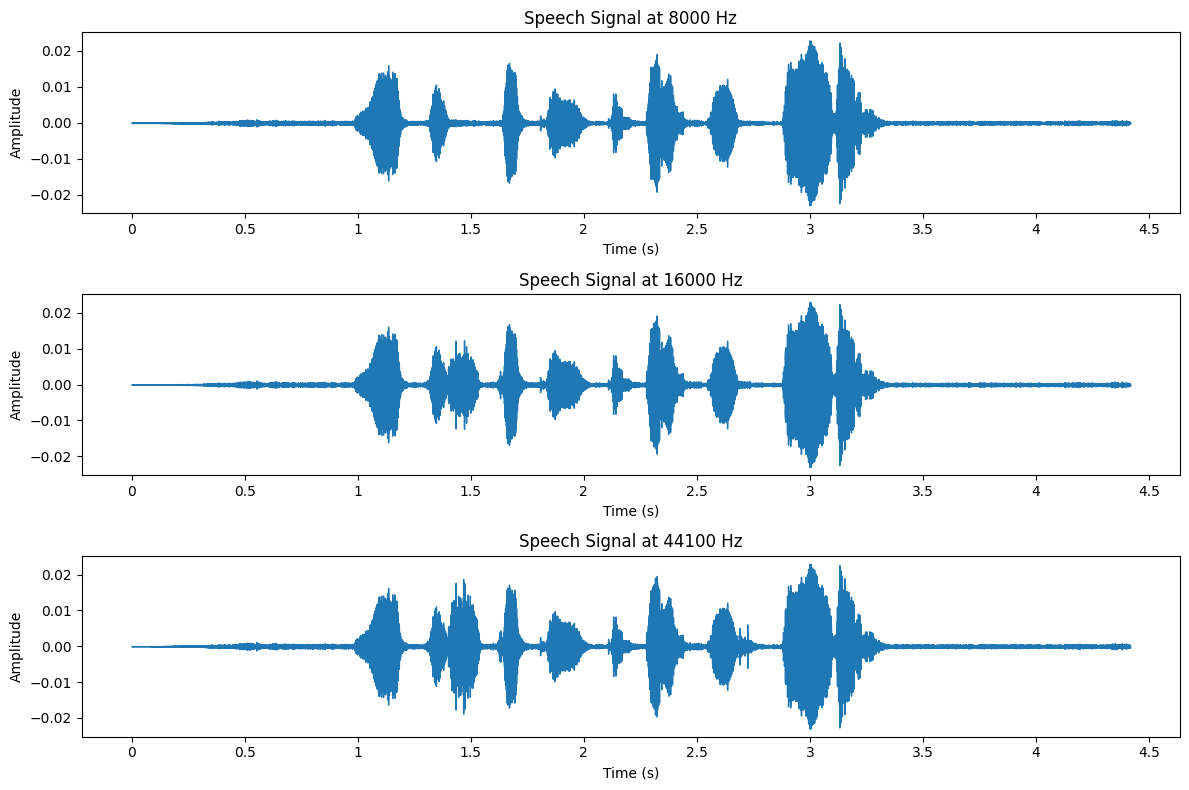

In [35]:
# (c) Plot sampled signals
# ---------------------------
plt.figure(figsize=(12, 8))

for i, (target_sr, resampled) in enumerate(resampled_signals.items(), 1):
    plt.subplot(len(target_rates), 1, i)
    librosa.display.waveshow(resampled, sr=target_sr)
    plt.title(f"Speech Signal at {target_sr} Hz")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

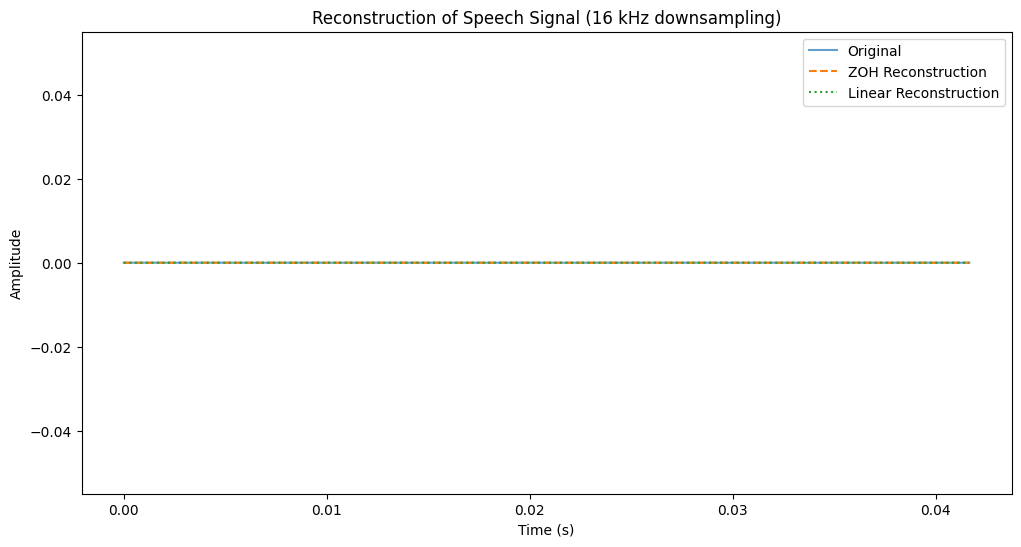


Sampling Rate: 8000 Hz
  ZOH MSE     = 0.000001
  Linear MSE  = 0.000001

Sampling Rate: 16000 Hz
  ZOH MSE     = 0.000000
  Linear MSE  = 0.000000

Sampling Rate: 44100 Hz
  ZOH MSE     = 0.000000
  Linear MSE  = 0.000000


In [36]:
# Helper function: MSE
def mse(x, y):
    min_len = min(len(x), len(y))
    return np.mean((x[:min_len] - y[:min_len])**2)

mse_results = {}

for target_sr in target_rates:
    # Downsample
    down = librosa.resample(signal, orig_sr=sr, target_sr=target_sr)

    # Create time axes
    t_orig = np.linspace(0, len(signal)/sr, len(signal))
    t_down = np.linspace(0, len(signal)/sr, len(down))

    # (i) Zero-Order Hold (nearest)
    f_zoh = interp1d(t_down, down, kind='nearest', fill_value="extrapolate")
    rec_zoh = f_zoh(t_orig)

    # (ii) Linear Interpolation
    f_lin = interp1d(t_down, down, kind='linear', fill_value="extrapolate")
    rec_lin = f_lin(t_orig)

    # Store
    reconstructed[target_sr] = (rec_zoh, rec_lin)

    # Calculate MSE
    mse_results[target_sr] = {
        "ZOH": mse(signal, rec_zoh),
        "Linear": mse(signal, rec_lin)
    }

# ---------------------------
# Plot Example (16 kHz case)
# ---------------------------
plt.figure(figsize=(12,6))
plt.plot(t_orig[:2000], signal[:2000], label="Original", alpha=0.7)
plt.plot(t_orig[:2000], reconstructed[16000][0][:2000], label="ZOH Reconstruction", linestyle='--')
plt.plot(t_orig[:2000], reconstructed[16000][1][:2000], label="Linear Reconstruction", linestyle=':')
plt.legend()
plt.title("Reconstruction of Speech Signal (16 kHz downsampling)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Print MSE Results
for rate in mse_results:
    print(f"\nSampling Rate: {rate} Hz")
    print(f"  ZOH MSE     = {mse_results[rate]['ZOH']:.6f}")
    print(f"  Linear MSE  = {mse_results[rate]['Linear']:.6f}")

In [37]:
# Print MSE Results
for rate in mse_results:
    print(f"\nSampling Rate: {rate} Hz")
    print(f"  ZOH MSE     = {mse_results[rate]['ZOH']:.6f}")
    print(f"  Linear MSE  = {mse_results[rate]['Linear']:.6f}")


Sampling Rate: 8000 Hz
  ZOH MSE     = 0.000001
  Linear MSE  = 0.000001

Sampling Rate: 16000 Hz
  ZOH MSE     = 0.000000
  Linear MSE  = 0.000000

Sampling Rate: 44100 Hz
  ZOH MSE     = 0.000000
  Linear MSE  = 0.000000


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d
import pandas as pd
from scipy.io import wavfile

In [39]:
# 1. Parameters
fs_high = 44100           # high-rate sampling (Hz) — ground truth
duration = 0.6            # seconds
t = np.arange(0, duration, 1/fs_high)

f0 = 120.0                # Fundamental frequency (Hz)
voiced_weight = 0.9
unvoiced_weight = 1 - voiced_weight


In [40]:
# 2. Source signal
# Glottal pulse train
period = int(round(fs_high / f0))
impulses = np.zeros_like(t)
impulses[::period] = 1.0

glottal_len = int(0.002 * fs_high)  # ~2 ms pulse
gw = np.hanning(glottal_len)
glottal = np.convolve(impulses, gw, mode='same')

# Unvoiced noise
np.random.seed(42)
noise = np.random.randn(len(t))
b_hp, a_hp = signal.butter(2, 200/(fs_high/2), btype='high')
noise = signal.lfilter(b_hp, a_hp, noise)

# Combine
source = voiced_weight * glottal + unvoiced_weight * 0.2 * noise

In [41]:
# 3. Vocal tract filter (all-pole from formants)
formants = [(700, 80), (1220, 90), (2600, 120)]
a_total = np.array([1.0])
for f_formant, bw in formants:
    r = np.exp(-np.pi * bw / fs_high)
    omega = 2 * np.pi * f_formant / fs_high
    a_section = np.array([1.0, -2*r*np.cos(omega), r*r])
    a_total = np.convolve(a_total, a_section)

b_total = np.array([1.0])
speech = signal.lfilter(b_total, a_total, source)

speech = speech / np.max(np.abs(speech)) * 0.9
source = source / np.max(np.abs(source)) * 0.9

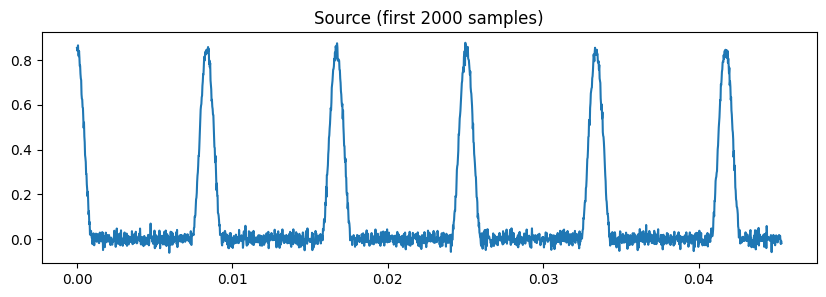

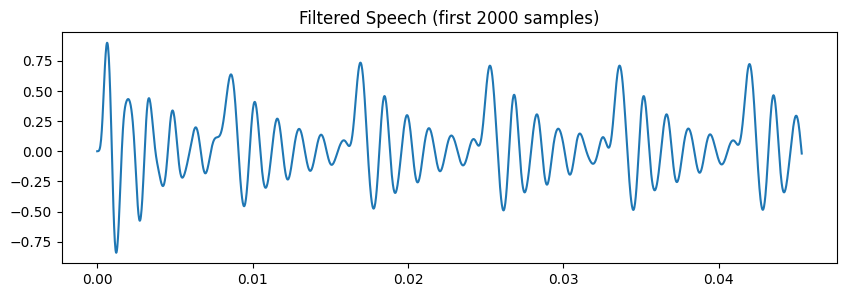

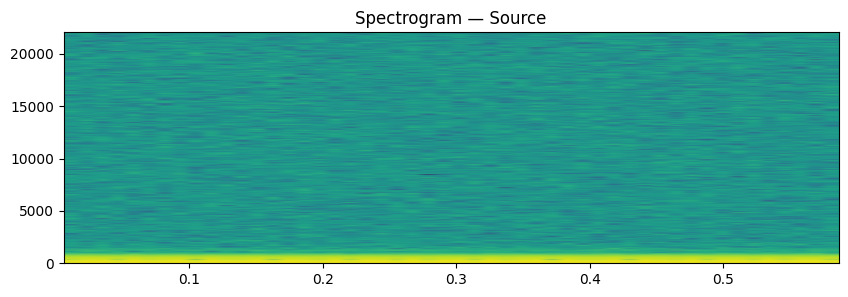

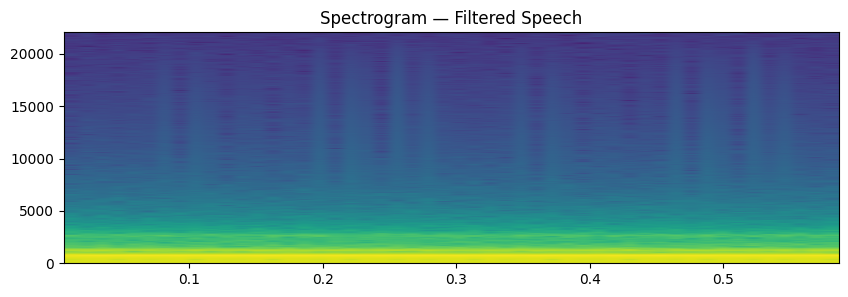

In [42]:
# 4. Plot source vs speech
plt.figure(figsize=(10, 3))
plt.plot(t[:2000], source[:2000])
plt.title("Source (first 2000 samples)")
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t[:2000], speech[:2000])
plt.title("Filtered Speech (first 2000 samples)")
plt.show()

# Spectrograms
plt.figure(figsize=(10, 3))
plt.specgram(source, NFFT=1024, Fs=fs_high, noverlap=512)
plt.title("Spectrogram — Source")
plt.show()

plt.figure(figsize=(10, 3))
plt.specgram(speech, NFFT=1024, Fs=fs_high, noverlap=512)
plt.title("Spectrogram — Filtered Speech")
plt.show()


In [43]:
# 5. Sampling + reconstruction
target_rates = [8000, 16000, 44100]
mse_results = []

for fs_t in target_rates:
    t_sampled = np.arange(0, duration, 1/fs_t)
    sampled_values = np.interp(t_sampled, t, speech)

    # ZOH
    interp_zoh = interp1d(t_sampled, sampled_values, kind='nearest',
                          bounds_error=False, fill_value=(sampled_values[0], sampled_values[-1]))
    recon_zoh = interp_zoh(t)

    # Linear
    interp_lin = interp1d(t_sampled, sampled_values, kind='linear',
                          bounds_error=False, fill_value=(sampled_values[0], sampled_values[-1]))
    recon_lin = interp_lin(t)

    # MSE
    mse_zoh = np.mean((speech - recon_zoh)**2)
    mse_lin = np.mean((speech - recon_lin)**2)

    mse_results.append({'fs_target': fs_t, 'method': 'zoh', 'mse': mse_zoh})
    mse_results.append({'fs_target': fs_t, 'method': 'linear', 'mse': mse_lin})

# 6. Show MSE results
mse_df = pd.DataFrame(mse_results)
print(mse_df.pivot(index='fs_target', columns='method', values='mse'))


method       linear       zoh
fs_target                    
8000       0.000039  0.001265
16000      0.000003  0.000317
44100      0.000000  0.000000


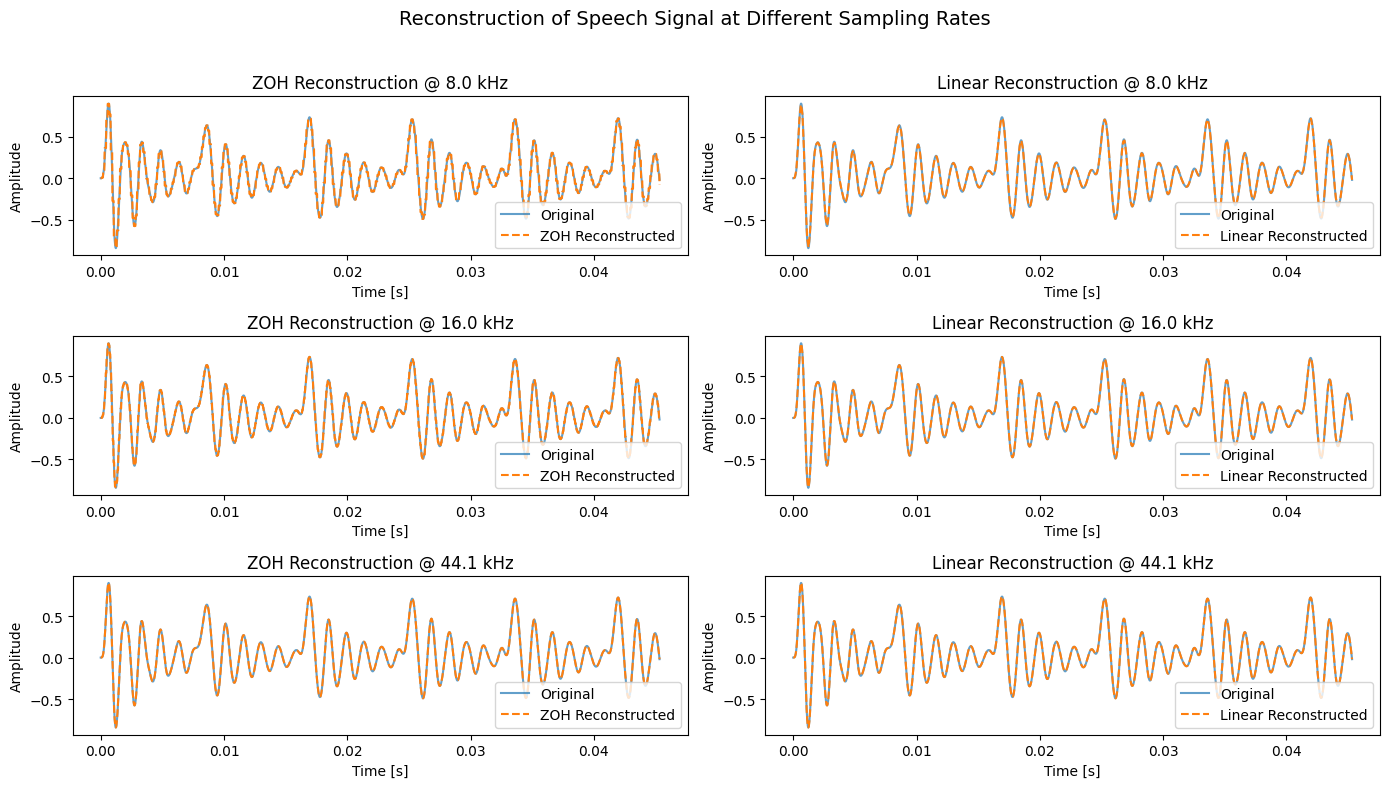

In [44]:
# -------------------------------
# Plot reconstructed signals
# -------------------------------
fig, axes = plt.subplots(len(target_rates), 2, figsize=(14, 8))
fig.suptitle("Reconstruction of Speech Signal at Different Sampling Rates", fontsize=14)

for i, fs_t in enumerate(target_rates):
    t_sampled = np.arange(0, duration, 1/fs_t)
    sampled_values = np.interp(t_sampled, t, speech)

    # Reconstruct (ZOH + Linear)
    interp_zoh = interp1d(t_sampled, sampled_values, kind='nearest',
                          bounds_error=False, fill_value=(sampled_values[0], sampled_values[-1]))
    recon_zoh = interp_zoh(t)

    interp_lin = interp1d(t_sampled, sampled_values, kind='linear',
                          bounds_error=False, fill_value=(sampled_values[0], sampled_values[-1]))
    recon_lin = interp_lin(t)

    # Plot ZOH reconstruction
    axes[i, 0].plot(t[:2000], speech[:2000], label="Original", alpha=0.7)
    axes[i, 0].plot(t[:2000], recon_zoh[:2000], label="ZOH Reconstructed", linestyle='--')
    axes[i, 0].set_title(f"ZOH Reconstruction @ {fs_t/1000:.1f} kHz")
    axes[i, 0].legend()
    axes[i, 0].set_xlabel("Time [s]")
    axes[i, 0].set_ylabel("Amplitude")

    # Plot Linear reconstruction
    axes[i, 1].plot(t[:2000], speech[:2000], label="Original", alpha=0.7)
    axes[i, 1].plot(t[:2000], recon_lin[:2000], label="Linear Reconstructed", linestyle='--')
    axes[i, 1].set_title(f"Linear Reconstruction @ {fs_t/1000:.1f} kHz")
    axes[i, 1].legend()
    axes[i, 1].set_xlabel("Time [s]")
    axes[i, 1].set_ylabel("Amplitude")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [45]:
# 7. Save audio (optional)
wavfile.write("speech_44100.wav", fs_high, (speech * 32767).astype(np.int16))